# Deep Learning Assignment 2 - GAT Trajectory Prediction

**Author:**
Arian Ghadirzadeh

---

### Data Preparation Module

To clean and process the raw pedestrian trajectory dataset, I developed a custom class `PedestrianGraphProcessor`.  
This class handles the entire preprocessing pipeline including:

- Reading and cleaning the `.nodes` and `.edges` files
- Dropping invalid or missing values
- Visualizing sample pedestrian trajectories and graph structure
- Performing feature engineering (e.g., delta_x and delta_y)
- Building the graph structure using `networkx` and converting it to a normalized sparse adjacency matrix
- Preparing the final `X`, `y`, and adjacency matrix `A_norm` for the GNN
- Providing a ready-to-use `SingleLoader` from Spektral for training

The class is fully modular and designed for reusability across different trajectory scenes.

---


## Imports


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from spektral.layers import GATConv
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from spektral.data import Dataset, Graph
from spektral.data.loaders import SingleLoader
from spektral.utils import normalized_adjacency
from tensorflow.keras.optimizers import Adam

In [90]:
class PedestrianGraphProcessor:
    def __init__(self, nodes_path: str, edges_path: str):
        self.nodes_path = Path(nodes_path)
        self.edges_path = Path(edges_path)

        self.nodes_df = None
        self.edges_df = None
        self.filtered_nodes_df = None
        self.A = None
        self.A_norm = None
        self.X = None
        self.y = None
        self.features = ['current_x', 'current_y', 'delta_x', 'delta_y']
        self.ordered_node_ids = None

    def load_and_clean_data(self):
        # Load data
        self.nodes_df = pd.read_csv(self.nodes_path, header=None, na_values=['_'])
        self.edges_df = pd.read_csv(self.edges_path, header=None)

        self.nodes_df.columns = ['node_id', 'current_x', 'current_y', 'prev_x', 'prev_y', 'future_x', 'future_y']
        self.edges_df.columns = ['target', 'source']

        # Drop missing values
        self.nodes_df = self.nodes_df.dropna().reset_index(drop=True)
        self.edges_df = self.edges_df[(self.edges_df['target'] != -1) & (self.edges_df['source'] != -1)].reset_index(drop=True)

    def visualize_sample_movements(self, sample_size=10):
        sample_nodes = self.nodes_df.sample(sample_size, random_state=42)

        plt.figure(figsize=(8, 8))
        for _, row in sample_nodes.iterrows():
            x_vals = [row['prev_x'], row['current_x'], row['future_x']]
            y_vals = [row['prev_y'], row['current_y'], row['future_y']]
            plt.plot(x_vals, y_vals, marker='o')
            plt.text(row['future_x'], row['future_y'], str(int(row['node_id'])), fontsize=8)

        plt.title("Trajectories of Sample Pedestrians")
        plt.xlabel("X coordinate")
        plt.ylabel("Y coordinate")
        plt.grid(True)
        plt.axis('equal')
        plt.show()

        sample_ids = sample_nodes['node_id'].astype(int).tolist()
        sample_edges = self.edges_df[
            self.edges_df['source'].isin(sample_ids) & self.edges_df['target'].isin(sample_ids)
        ]

        sample_graph = nx.DiGraph()
        sample_graph.add_edges_from(sample_edges[['source', 'target']].values)

        pos = {
            int(row['node_id']): (row['current_x'], row['current_y'])
            for _, row in sample_nodes.iterrows()
        }

        plt.figure(figsize=(10, 8))
        nx.draw(
            sample_graph, pos,
            with_labels=True, node_size=800, node_color="skyblue",
            edge_color="gray", font_size=10, arrows=True, linewidths=1.5
        )
        plt.title("Graph + Trajectories of Sample Pedestrians")
        plt.xlabel("X coordinate")
        plt.ylabel("Y coordinate")
        plt.grid(True)
        plt.axis("equal")
        plt.show()

    def build_graph_and_features(self):
        # Feature engineering
        self.nodes_df['delta_x'] = self.nodes_df['current_x'] - self.nodes_df['prev_x']
        self.nodes_df['delta_y'] = self.nodes_df['current_y'] - self.nodes_df['prev_y']

        # Build graph
        G = nx.DiGraph()
        G.add_edges_from(self.edges_df[['source', 'target']].values)

        self.ordered_node_ids = [n for n in self.nodes_df['node_id'].astype(int) if n in G]

        self.A = nx.to_scipy_sparse_array(G, nodelist=self.ordered_node_ids, format='coo')
        self.A_norm = normalized_adjacency(self.A)

        self.filtered_nodes_df = self.nodes_df[self.nodes_df['node_id'].isin(self.ordered_node_ids)].copy()
        self.filtered_nodes_df = self.filtered_nodes_df.set_index('node_id').loc[self.ordered_node_ids].reset_index()

        self.X = self.filtered_nodes_df[self.features].values.astype(np.float32)
        self.y = self.filtered_nodes_df[['future_x', 'future_y']].values.astype(np.float32)

    def get_loader(self, epochs=300):
        class MyGraphDataset(Dataset):
            def read(inner_self):
                return [Graph(x=self.X, a=self.A_norm, y=self.y)]

        dataset = MyGraphDataset()
        return SingleLoader(dataset, epochs=epochs)

    def get_data(self):
        return self.X, self.y, self.A_norm


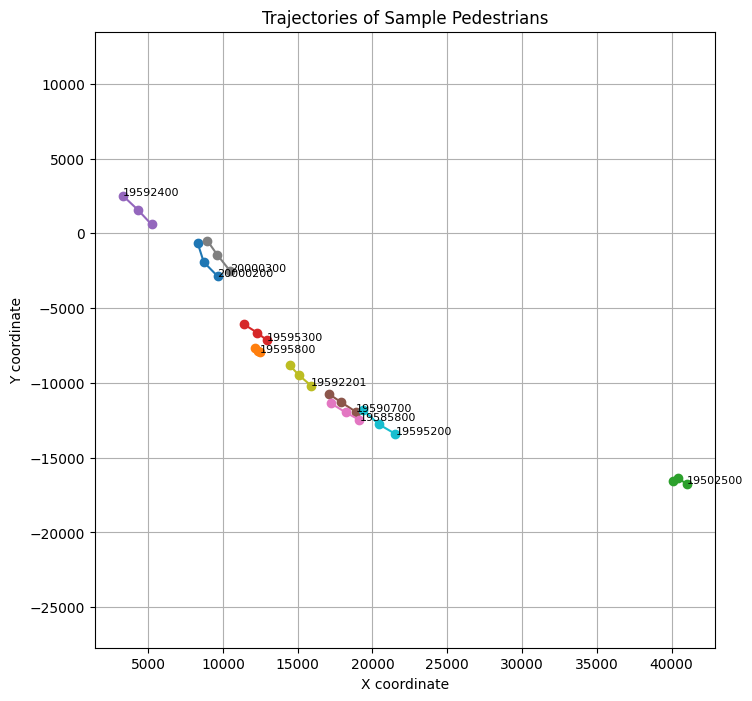

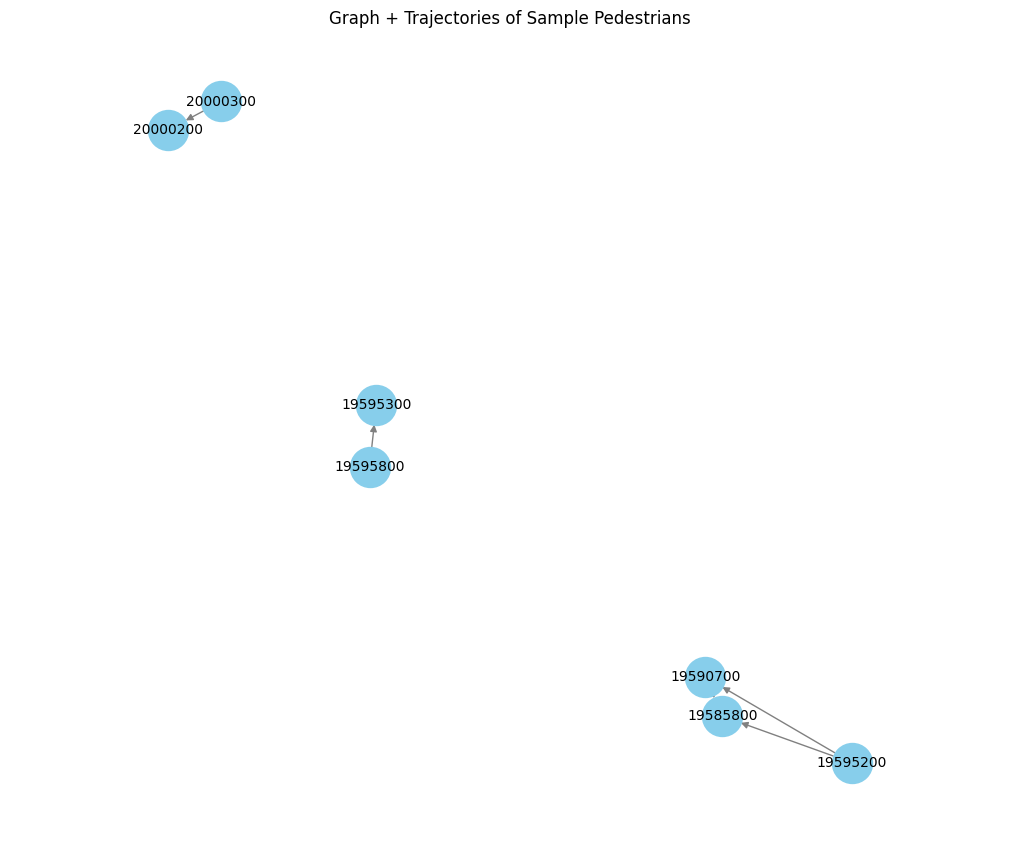

In [ ]:
# Test the class
nodes_path = "data/135289080722.nodes"
edges_path = "data/135289080722.edges"

processor = PedestrianGraphProcessor(nodes_path, edges_path)
processor.load_and_clean_data()
processor.visualize_sample_movements()
processor.build_graph_and_features()

X, y, A = processor.get_data()
loader = processor.get_loader(epochs=300)

### Modular GAT Model Builder

We define a modular class `CustomGATBuilder` to streamline experimentation with different GAT architectures.  
This class allows switching between the standard attention-based GAT and a custom cosine similarity variant by simply changing a mode argument.

**Key features:**

- `build_standard_gat()`: builds a traditional GAT model using `GATConv` layers from Spektral
- `build_cosine_gat()`: builds a GAT variant where attention weights are replaced with cosine similarity
- `build(mode='standard' or 'cosine')`: unified interface to construct the desired model

This structure improves maintainability and makes it easier to experiment with architectural variations for analysis and comparison.


In [92]:
from spektral.layers import ops
from tensorflow.keras.layers import Lambda

class CustomGATBuilder:
    def __init__(self, input_shape, adj_shape, n_output=2):
        self.input_shape = input_shape
        self.adj_shape = adj_shape
        self.n_output = n_output

    def build_standard_gat(self, channels=8, heads=1, activation='elu'):
        X_in = Input(shape=(self.input_shape,), name="X_in")
        A_in = Input(shape=(self.adj_shape,), sparse=True, name="A_in")

        x = GATConv(channels, activation=activation, attn_heads=heads)([X_in, A_in])
        x = GATConv(channels, activation=activation, attn_heads=heads)([x, A_in])
        output = Dense(self.n_output)(x)

        model = Model(inputs=[X_in, A_in], outputs=output)
        return model

    def build_cosine_gat(self, channels=8, activation='elu'):
        X_in = Input(shape=(self.input_shape,), name="X_in")
        A_in = Input(shape=(self.adj_shape,), sparse=True, name="A_in")

        def cosine_attention(inputs):
            X, A = inputs
            X_norm = tf.math.l2_normalize(X, axis=-1)
            attn_matrix = tf.matmul(X_norm, X_norm, transpose_b=True)
            attn_matrix = tf.multiply(tf.sparse.to_dense(A), attn_matrix)
            return tf.matmul(attn_matrix, X)

        x = Dense(channels, activation=activation)(X_in)
        x = Lambda(cosine_attention)([x, A_in])
        x = Dense(channels, activation=activation)(x)
        output = Dense(self.n_output)(x)

        model = Model(inputs=[X_in, A_in], outputs=output)
        return model

    def build(self, mode='standard', **kwargs):
        if mode == 'standard':
            return self.build_standard_gat(**kwargs)
        elif mode == 'cosine':
            return self.build_cosine_gat(**kwargs)
        else:
            raise ValueError("Mode must be 'standard' or 'cosine'")


In [93]:
# Test the class

# builder = CustomGATBuilder(input_shape=X.shape[1], adj_shape=A.shape[0])
# model_standard = builder.build(mode='standard', heads=4)
# model_cosine = builder.build(mode='cosine')

### Training & Evaluation Module: `GATTrainer`

The `GATTrainer` class encapsulates the entire training, evaluation, and visualization pipeline for GAT models.

**Key features:**

- `train()`: trains the given model on a provided `Spektral` data loader
- `evaluate(X_true)`: computes the Mean Squared Error (MSE) on the predictions
- `plot_loss()`: visualizes the training loss curve
- `get_predictions()`: returns the predicted coordinates

This modular design ensures cleaner code and makes it easier to benchmark and compare different GAT architectures, including standard and custom cosine-based variants.


In [94]:
class GATTrainer:
    def __init__(self, model, loader, learning_rate=0.01):
        self.model = model
        self.loader = loader
        self.learning_rate = learning_rate
        self.history = None
        self.y_pred = None
        self.mse = None

        self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')

    def train(self, epochs=30, verbose=1):
        self.history = self.model.fit(
            self.loader.load(),
            steps_per_epoch=self.loader.steps_per_epoch,
            epochs=epochs,
            verbose=verbose
        )
        return self.history

    def evaluate(self, X_true):
        self.y_pred = self.model.predict(self.loader.load(), steps=self.loader.steps_per_epoch, verbose=0)
        self.mse = np.mean((X_true - self.y_pred) ** 2)
        print(f"✅ Final MSE: {self.mse:.2f}")
        return self.mse

    def plot_loss(self, label=None):
        if not self.history:
            raise ValueError("Train the model before plotting loss.")

        plt.plot(self.history.history['loss'], label=label or 'Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Training Loss Over Epochs')
        plt.grid(True)
        if label:
            plt.legend()
        plt.tight_layout()
        plt.show()

    def get_predictions(self):
        return self.y_pred


In [95]:
# Test the class

# model = builder.build(mode='standard', heads=4)
# trainer = GATTrainer(model=model, loader=loader)
# trainer.train(epochs=30)
# trainer.evaluate(y)
# trainer.plot_loss()

### Experiment 1 – Standard GAT (8 Heads)

In this baseline experiment, I use a standard Graph Attention Network (GAT) with 8 attention heads and two `GATConv` layers.
This setup allows the model to aggregate diverse information from neighbors at each layer.

- **Architecture**: GATConv (8 heads) → GATConv (8 heads) → Dense(2)
- **Attention Heads**: 8
- **Epochs**: 30


/Users/hossein/.pyenv/versions/3.9.18/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/30
1/1 [==============================] - 0s 396ms/step - loss: 191930816.0000
Epoch 2/30
1/1 [==============================] - 0s 2ms/step - loss: 142740480.0000
Epoch 3/30
1/1 [==============================] - 0s 1ms/step - loss: 84029712.0000
Epoch 4/30
1/1 [==============================] - 0s 1ms/step - loss: 31792358.0000
Epoch 5/30
1/1 [==============================] - 0s 2ms/step - loss: 51190252.0000
Epoch 6/30
1/1 [==============================] - 0s 1ms/step - loss: 40444104.0000
Epoch 7/30
1/1 [==============================] - 0s 2ms/step - loss: 49831488.0000
Epoch 8/30
1/1 [==============================] - 0s 1ms/step - loss: 58420408.0000
Epoch 9/30
1/1 [==============================] - 0s 2ms/step - loss: 66665096.0000
Epoch 10/30
1/1 [==============================] - 0s 1ms/step - loss: 33809876.0000
Epoch 11/30
1/1 [==============================] - 0s 2ms/step - loss: 29401060.0000
Epoch 12/30
1/1 [==============================] - 0s 1ms/step - loss:

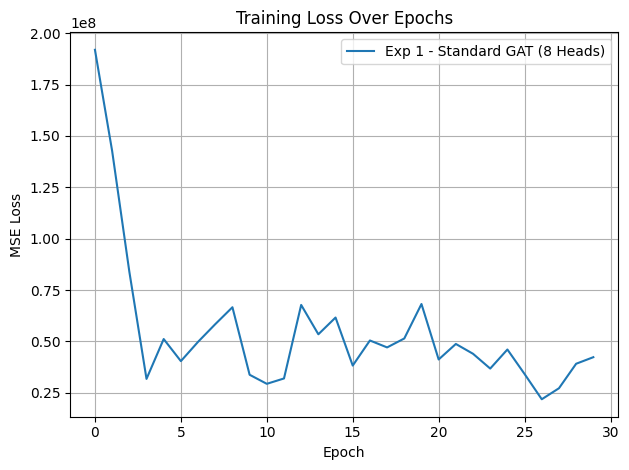

In [ ]:
# Data processing
nodes_path = "data/135289080722.nodes"
edges_path = "data/135289080722.edges"

processor = PedestrianGraphProcessor(nodes_path, edges_path)
processor.load_and_clean_data()
processor.build_graph_and_features()
X, y, A_norm = processor.get_data()
loader = processor.get_loader(epochs=30)

# Model and training
builder = CustomGATBuilder(input_shape=X.shape[1], adj_shape=A_norm.shape[0])
model = builder.build(mode='standard', heads=8)

trainer = GATTrainer(model, loader)
trainer.train(epochs=30)
trainer.evaluate(y)
trainer.plot_loss(label="Exp 1 - Standard GAT (8 Heads)")

### Experiment 2 – Attention Heads Comparison (4 vs 1)

In this experiment, I compare the impact of the number of attention heads in GAT layers on the model’s performance. We run two models with identical architectures, varying only in the number of attention heads:

- **Model B**: GATConv (4 heads) → GATConv (4 heads) → Dense(2)
- **Model A**: GATConv (1 head) → GATConv (1 head) → Dense(2)

- **Epochs**: 30 for both variants
- **Result**: The loss curves show that 4 heads converged better and more stably compared to 1 head.


Epoch 1/30
1/1 [==============================] - 0s 388ms/step - loss: 167168640.0000
Epoch 2/30
1/1 [==============================] - 0s 1ms/step - loss: 165768848.0000
Epoch 3/30
1/1 [==============================] - 0s 1ms/step - loss: 160099744.0000
Epoch 4/30
1/1 [==============================] - 0s 1ms/step - loss: 154549488.0000
Epoch 5/30
1/1 [==============================] - 0s 1ms/step - loss: 143156352.0000
Epoch 6/30
1/1 [==============================] - 0s 2ms/step - loss: 142875296.0000
Epoch 7/30
1/1 [==============================] - 0s 2ms/step - loss: 161791568.0000
Epoch 8/30
1/1 [==============================] - 0s 1ms/step - loss: 149932544.0000
Epoch 9/30
1/1 [==============================] - 0s 2ms/step - loss: 160336112.0000
Epoch 10/30
1/1 [==============================] - 0s 1ms/step - loss: 156712128.0000
Epoch 11/30
1/1 [==============================] - 0s 1ms/step - loss: 132203664.0000
Epoch 12/30
1/1 [==============================] - 0s 1ms/ste

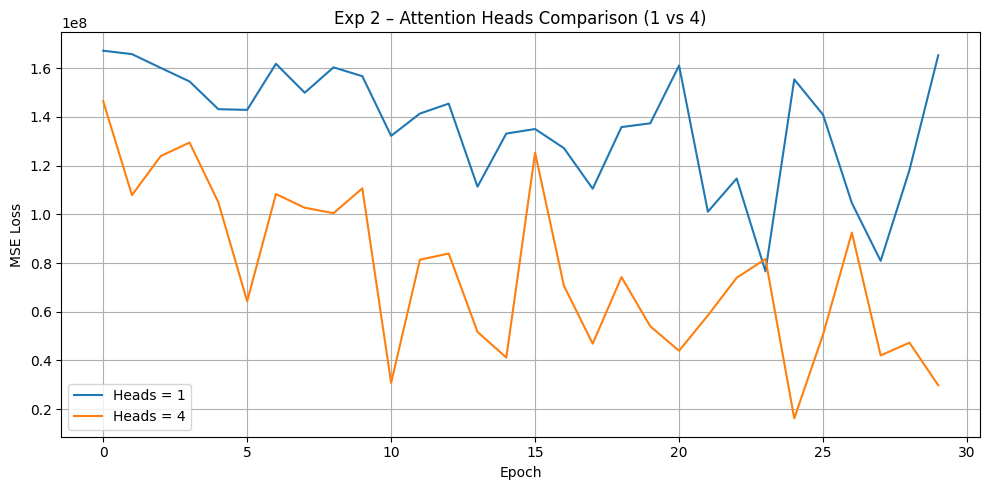

In [97]:
model_1_head = builder.build(mode='standard', heads=1)
model_4_heads = builder.build(mode='standard', heads=4)

model_1_head = GATTrainer(model_1_head, loader)
trainer_4_heads = GATTrainer(model_4_heads, loader)

history_2 = model_1_head.train(epochs=30)
history_4 = trainer_4_heads.train(epochs=30)

loss_1 = history_2.history['loss']
loss_4 = history_4.history['loss']

model_1_head.evaluate(y)
trainer_4_heads.evaluate(y)

plt.figure(figsize=(10, 5))
plt.plot(loss_1, label='Heads = 1')
plt.plot(loss_4, label='Heads = 4')
plt.title('Exp 2 – Attention Heads Comparison (1 vs 4)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Experiment 3 – Deep Embedding + GAT (8 Attention Heads)

In this experiment, I explore the impact of applying a deeper embedding transformation before feeding node features into the GAT layers.  
The goal is to enhance the representation capacity by adding non-linear transformations via dense layers.

I maintain consistency with the baseline model by using **8 attention heads** in each GATConv layer.

- **Architecture**:  
  Dense(32, relu) → Dense(32, relu) → GATConv(8 × 8 heads, elu) → GATConv(8 × 8 heads, elu) → Dense(2)

- **Attention Heads**: 8
- **Epochs**: 30
- **Loss Function**: Mean Squared Error (MSE)


Epoch 1/30
1/1 [==============================] - 0s 417ms/step - loss: 166031792.0000
Epoch 2/30
1/1 [==============================] - 0s 2ms/step - loss: 145637216.0000
Epoch 3/30
1/1 [==============================] - 0s 2ms/step - loss: 129876368.0000
Epoch 4/30
1/1 [==============================] - 0s 2ms/step - loss: 69863280.0000
Epoch 5/30
1/1 [==============================] - 0s 2ms/step - loss: 23846052.0000
Epoch 6/30
1/1 [==============================] - 0s 2ms/step - loss: 191106688.0000
Epoch 7/30
1/1 [==============================] - 0s 2ms/step - loss: 52408652.0000
Epoch 8/30
1/1 [==============================] - 0s 1ms/step - loss: 51947360.0000
Epoch 9/30
1/1 [==============================] - 0s 2ms/step - loss: 40891044.0000
Epoch 10/30
1/1 [==============================] - 0s 1ms/step - loss: 63997972.0000
Epoch 11/30
1/1 [==============================] - 0s 2ms/step - loss: 80292032.0000
Epoch 12/30
1/1 [==============================] - 0s 4ms/step - los

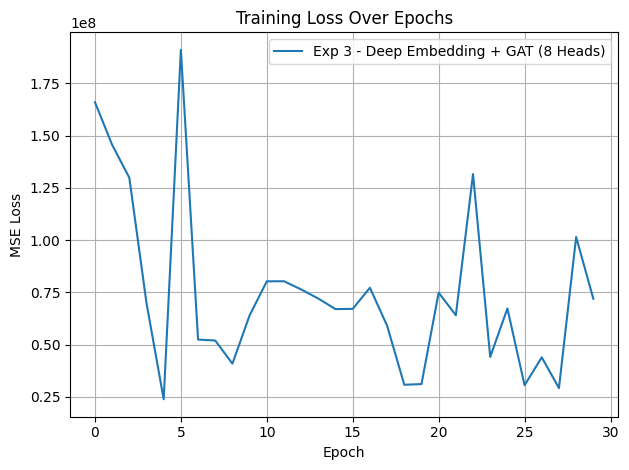

In [98]:
# Input shapes
N = A.shape[0]
F = X.shape[1]
n_out = y.shape[1]

# Input layers
X_in = Input(shape=(F,))
A_in = Input(shape=(N,), sparse=True)

# Deeper embedding before GAT
h = Dense(32, activation='relu')(X_in)
h = Dense(32, activation='relu')(h)

# GAT layers with 8 heads
x = GATConv(8, attn_heads=8, activation='elu')([h, A_in])
x = GATConv(8, attn_heads=8, activation='elu')([x, A_in])
output = Dense(n_out)(x)

model = Model(inputs=[X_in, A_in], outputs=output)
trainer = GATTrainer(model, loader)
trainer.train(epochs=30)
trainer.evaluate(y)
trainer.plot_loss(label="Exp 3 - Deep Embedding + GAT (8 Heads)")

### Experiment 4 – Cosine Similarity Attention (No Multi-Head)

In this experiment, I replace the learned attention mechanism in GAT with a fixed similarity measure: **cosine similarity**.  
Instead of learning attention weights through backpropagation, each node assigns attention based on the cosine similarity of its feature vector with its neighbors.

Unlike standard `GATConv`, this implementation does **not** include multi-head attention — only one cosine-based attention is applied per node.

- **Architecture**:  
  Dense(8, relu) → CosineAttention → Dense(8, relu) → Dense(2)

- **Attention Heads**: 1 (fixed, non-learned)
- **Epochs**: 30
- **Loss Function**: Mean Squared Error (MSE)


Epoch 1/30
1/1 [==============================] - 0s 102ms/step - loss: 165272544.0000
Epoch 2/30
1/1 [==============================] - 0s 1ms/step - loss: 165132704.0000
Epoch 3/30
1/1 [==============================] - 0s 1ms/step - loss: 164955712.0000
Epoch 4/30
1/1 [==============================] - 0s 1ms/step - loss: 164739376.0000
Epoch 5/30
1/1 [==============================] - 0s 1ms/step - loss: 164480592.0000
Epoch 6/30
1/1 [==============================] - 0s 1ms/step - loss: 164175760.0000
Epoch 7/30
1/1 [==============================] - 0s 1ms/step - loss: 163821920.0000
Epoch 8/30
1/1 [==============================] - 0s 1ms/step - loss: 163416416.0000
Epoch 9/30
1/1 [==============================] - 0s 1ms/step - loss: 162956416.0000
Epoch 10/30
1/1 [==============================] - 0s 1ms/step - loss: 162439120.0000
Epoch 11/30
1/1 [==============================] - 0s 1ms/step - loss: 161861584.0000
Epoch 12/30
1/1 [==============================] - 0s 1ms/ste

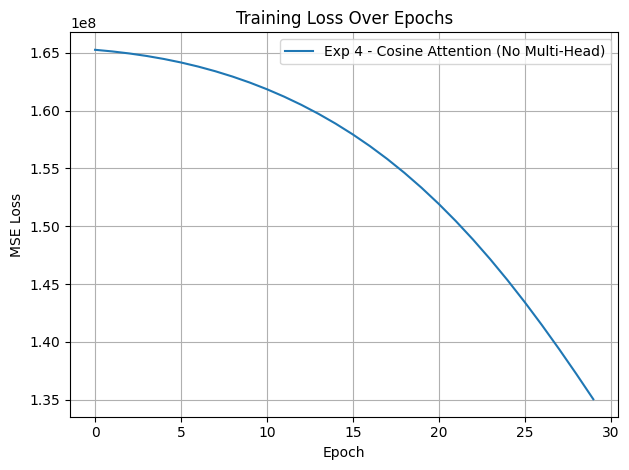

In [99]:
model = builder.build(mode='cosine')
trainer = GATTrainer(model, loader)
trainer.train(epochs=30)
trainer.evaluate(y)
trainer.plot_loss(label="Exp 4 - Cosine Attention (No Multi-Head)")